In [ ]:
!pip install ohmeow-blurr -q
!pip install datasets -q
!pip install bert-score -q

     |████████████████████████████████| 91 kB 1.2 MB/s 
     |████████████████████████████████| 186 kB 27.2 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 1.2 MB 32.3 MB/s 
     |████████████████████████████████| 285 kB 49.1 MB/s 
     |████████████████████████████████| 2.9 MB 14.9 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 51 kB 307 kB/s 
     |████████████████████████████████| 895 kB 36.9 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 3.3 MB 35.2 MB/s 
     |████████████████████████████████| 596 kB 43.4 MB/s 
     |████████████████████████████████| 1.3 MB 48.3 MB/s 
     |████████████████████████████████| 125 kB 54.2 MB/s 
     |████████████████████████████████| 243 kB 29.1 MB/s 
     |████████████████████████████████| 271 kB 52.1 MB/s 
     |████████████████████

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/Shareddrives/KLUE Summarization/

In [ ]:
import json
import pandas as pd


def read_jsonl(path):
  DATA_DIR = "문서요약 텍스트_unzip"
  with open(DATA_DIR + path , 'r') as json_file:
      json_list = list(json_file)

  trains = []
  for json_str in json_list:
      line = json.loads(json_str)
      trains.append(line)
  df = pd.DataFrame(trains)
  return df

train_df = read_jsonl('/1.Training/신문기사_1.train.jsonl/train.jsonl')
val_df = read_jsonl('/2.Validation/신문기사_1.vaild.jsonl/vaild.jsonl')
train_df.head()

In [ ]:
def clean(df):
    article = []

    for i in range(df.shape[0]):
        text = ''
        for j in range(len(df['article_original'][i])):
            text += " " + df['article_original'][i][j]
        article.append(text)

    df['article'] = article

    return df

In [ ]:
clean(train_df)

df = train_df[:80000]

In [ ]:
import datasets
import pandas as pd
from fastai.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

pretrained_model_name = "hyunwoongko/kobart"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
                                                                  model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/109 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/172k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473M [00:00<?, ?B/s]

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [ ]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task='summarization')
text_gen_kwargs['max_length'] = 80
text_gen_kwargs['min_length'] = 20

text_gen_kwargs

{'bad_words_ids': None,
 'bos_token_id': 0,
 'decoder_start_token_id': 2,
 'diversity_penalty': 0.0,
 'do_sample': False,
 'early_stopping': False,
 'encoder_no_repeat_ngram_size': 0,
 'eos_token_id': 1,
 'forced_bos_token_id': None,
 'forced_eos_token_id': 2,
 'length_penalty': 1.0,
 'max_length': 80,
 'min_length': 20,
 'no_repeat_ngram_size': 0,
 'num_beam_groups': 1,
 'num_beams': 1,
 'num_return_sequences': 1,
 'output_attentions': False,
 'output_hidden_states': False,
 'output_scores': False,
 'pad_token_id': 3,
 'remove_invalid_values': False,
 'repetition_penalty': 1.0,
 'return_dict_in_generate': False,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0,
 'use_cache': True}

In [ ]:
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                              max_length=650, max_tgt_length=130, text_gen_kwargs=text_gen_kwargs)

blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader('article'), get_y=ColReader('abstractive'), splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(df, bs=2)

In [ ]:
len(dls.train.items), len(dls.valid.items)

(64000, 16000)

In [ ]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 650]), torch.Size([2, 43]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"고등학생도 대학생처럼 자신이 원하는 과목을 골라 듣는 고교학점제가 내년부터 전국 51개 마이스터고 학생들을 대상으로 먼저 시작한다. 올해 초등 4학년생이 고교생이 되는 2025년에 고교학점제가 전면 시행되는 점을 고려해 교육과정이 비교적 탄력적인 마이스터고를 대상으로 미리 학점제를 도입해 정책 완성도를 높인다는 방침이다. 다만 졸업제도와 평가방식 등에 근본적인 변화가 아직 이뤄지지 않아 한계가 있다는 지적이다. 교육부는 21일 정부서울청사에서 이러한 내용의 '2020학년도 마이스터고 고교학점제 도입방안'을 발표했다. 문재인 정부의 국정과제인 고교학점제는 학생이 진로에 따라 원하는 과목을 선택·이수하고, 누적학점이 기준에 도달하면 졸업을 인정받는 제도다. 교육부는 마이스터고가 산업현장을 중심으로 이미 교육과정을 탄력적으로 운영하는 만큼 고교학점제를 우선 도입하기에 적합하다고 판단했다. 다만 유연성 확보를 위해 마이스터고 교육과정 이수 기준을 '단위'에서 '학점'으로 전환하고, 1학점 당 수업량을 현행 17회에서 16회로 줄였다. 총 이수학점도 현행 204단위에서 192학점으로 적정화해 수업시간을 줄인다. 박백범 교육부 차관은 ""(줄어든 시간만큼) 학교 자율운영과목의 확대, 학교 밖 학습경험 및 공동교육과정 운영활성화 등 학생 맞춤형 교육을 실현할 수 있는 여건을 조성할 것""이라며 ""산업체, 대학 및 전문대학, 지역교육시설 등 지역사회 학습장을 활용한 다양한 학교 밖 학습경험을 학점으로 인정할 예정""이라고 밝혔다. '융합형 인재' 양성을 위해 다른 전공의 수업을 들을 수 있는 제도도 마련한다. 전공 외 학과 수업을 24학점 이상 들으면 대학생처럼 '부전공'으로 인정해주는 등 학과별 칸막이를 허문다. 또 한 학과 안에서도 국가직무능력표준(NCS) 기반 교육과정과 연계한 세부 직무경로를 개설해 해당 분야에 필요한 전문 인력 양성을 추진한다. 전자과에서 소프트웨어과 과목을 수강하거나, 소프트웨어과 안에 소프트웨어개발과정과 정보보안 과정으로 세분화하는 식이다. 교육부는 수업별로 성취도가 떨어지는 학생들에 대비해 성취평가제(절대평가) 적용 일정에 따라 이수·미이수제(pass/fail)를 단계적으로 적용할 방침이다. 그러나 학점제를 먼저 도입하는 마이스터고는 전문교과 II만 성취평가제를 도입하고 나머지 교과는 우선 책임지도를 통해 학생들이 수업을 따라올 수 있도록 관리하기로 했다. 성취도는 A부터 E까지 다섯 단계로 나누고, E수준 범위 이내에서 최소 성취수준을 정한 뒤 이에 도달하지 못할 가능성이 높은 학생에 보충학습 등 '책임지도'를 실시한다. 고교학점제도 성공 여부에 핵심이 될 교원 전문성 강화를 위해서는 산학겸임교사 등 현장전문가의 교육 활동 참여를 확대한다. 또 취업지원인력과 진로전담교사를 2022년까지 모든 학교에 배치할 예정이다. 박 차관은 ""기존교사들은 주전공에 부전공 확대할 수 있도록 연수기회를 주고, 자기 전공에 대해서도 사내 현장 교육을 통해 심화할 수 있도록 할 것""이라고 설명했다. 그러나 일각에서는 현직 교사들의 적극적인 참여를 이끌기에는 약하다는 비판도 제기됐다. 익명을 요구한 현직 마이스터고 교사 A씨는 ""학년부장 등 중요한 역할을 수행해야 할 중견교사일수록 새로운 걸 배우길",고교학점제가 내년부터 전국 51개 마이스터고 학생들을 대상으로 미리 도입하여 시행해 졸업제도와 평가방식 등에 근본적인 변화에 대한 한계를 보완하여 정책 완성도를 높일 계획이다.
1,"고창군의회(의장 조규철)는 ‘현장에서 군민과 소통하며 함께하는 의회’를 슬로건으로 희망과 믿음을 주는 신뢰와 혁신의 의정활동을 펼치고 2019년 한 해 동안의 의정활동을 마무리 하였다. 군민에게 생생하고 여과 없는 민의수렴을 통하여 군민이 직접 참여하고 체감하는 투명한 열린 의정을 실현하며, 능동적이고 적극적인 의정운영으로 군민의 뜻을 바르게 대변하는 데 총력을 기울였다. 특히 ‘5.18 민주화운동 망언 자유한국당 규탄 결의문’을 채택하여 5.18 민주화운동 피해자과 가족 그리고 모든 국민을 향한 공개 사죄를 강력히 요구 하였으며, ‘고창군 평생학습도시 조성을 위한 결의문’을 채택하여 군민 누구에게나 열린 학습기회를 제공하고 자아실현을 위한 평생학습도시 구축을 지원하였다. ‘정읍시의회 동학농민혁명 특별법 개정 및 교과서 오류 수정 촉구 건의문에 대한 반대 건의안’을 통해 역사 왜곡에 강력히 반발 하였다. 또한 고창군의 자연경관은 우리 모두가 가꾸어야 자산으로 자연을 훼손하는 태양광발전소 설치와 같은 에너지 시설 허가를 반대하며 ‘심원면 염전부지 태양광 발전 시설 설치 반대 결의문’을 채택하였다. 그 외에도 ‘일본정부의 경제보복에 대한 규탄 결의문’ 채택 하였으며, 한빛원자력발전소 특별조사위원회에서는 ‘사용 후 핵연료 관리정책 재검토위원회’ 출범을 규탄하는 집회에 참석하여 구성방안에 대한 반대 입장을 표명하였으며, 한빛원자력 본부에 방문하여 ‘한빛원전 1호기 원자로 수동정지’와 관련해 현장 확인을 실시하고 안전문제에 대한 지역여론을 전달하였다. 아울러 정례회 시 본회의장에 300여명의 군민이 방청하여 의정활동을 함께 호흡하며 군민이 자발적으로 의정활동에 참여 할 수 있도록 유도하였다. 군정의 발전방안을 제시하고 정책 대안자로서 미래 지향적인 고창군을 위해 1차, 2차 정례회 시 군정질문 41건, 5분 자유발언 4건 등으로 군민의 의견을 반영 하고 행정사무감사를 통해 총 81건을 지적하고 개선을 요구하여 행정의 투명성과 효과성을 높이기 위해 노력했다. 올 한 해 동안 고창군의회는 두 차례의 정례회와 여섯 차례의 임시회를 통해 총 91일간의 회기 일정을 소화하며 조례안 80건, 예산 및 결산 9건, 결의안 5건, 동의안 21건, 건의안 1건, 기타 안건 29건 등 총 145건의 각종 안건을 처리하여 군민과 밀접하게 관련되어 있는 법규 등을 정비하였고, 총 2회에 걸쳐 주요 사업장 방문 및 주민과의 공감대화 등을 통해 현장에서의 고충과 애로를 청취하고 의견을 적극 수렴해 군정의 효율적 통제와 재정민주화 실현을 위해 힘썼다. 전년도 예산의 효율적 집행여부, 사업효과 등을 총체적으로 검토해 2020년도 본예산 6,302억원을 의결하였으며, 군민을 위한 예산이 적재적소에 편성 될 수 있도록 최선을 다했다. 총 10회의 의원간담회를 추진하여 비 회기동안에도 연속성 있는 의정활동을 전개하고 지역 현안에 대한 집행기관과의 상시 대화체계를 유지해 상호 이해증진을 도모하는 등 의원들이 함께 군정을 이해하고 대안을 마련하는 기회로 삼아 보다 역동적인 의정활동을 펼치는 계기를 마련했다. 조규철",고창군의회는 '현장에서 군민과 소통하는 의회'를 슬로건을 바탕으로 5.18 민주화운동 망언에 대한 자유한국당 규탄 결의문을 채택하고 평생학습도시 구축을 지원하는 등 군민이 직접 참여하고 체감하는 열린 의정을 실현하며 2019 의정활동을 마무리 했다.


In [ ]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'en' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [ ]:
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=ranger,
                loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.create_opt() 
learn.freeze()

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.93k [00:00<?, ?B/s]

SuggestedLRs(valley=0.0003311311302240938)

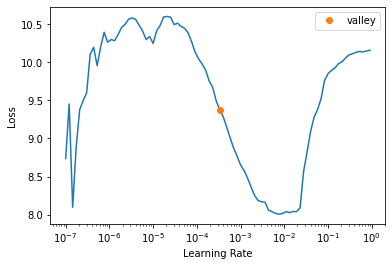

In [ ]:
learn.lr_find()

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(4,
 tensor(11.6136, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 38, 30000]))

In [ ]:
learn.fit_one_cycle(1, lr_max=3e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time


In [ ]:
learn.show_results(learner=learn, max_n=2)

In [ ]:
ls

In [ ]:
import pandas as pd
import re

reviews = pd.read_csv("/content/drive/Shareddrives/KLUE Summarization/klue crawling/aggregated.csv")
org_input = """""" + reviews['evaluation'][0]

org_input = re.sub('\n', ' ', org_input)
org_input

'수업 내용이 어려운 부분이 있지만, 교수님께서 질문에 대해 응답 잘 해주셔서 제 고민 많이 해결해주셨습니다. 귀여우시는분이세요..완전 꿀이에요!! 수업만 잘 따라가시면 하루 전날 공부해도 무리없습니다 ㅎㅎ 박경삼 교수님도 정말 좋으세요평가내용 ; 팀플 한 번 시험 두번  팀플 피드백 꽤 꼼꼼히 해주시고 변별력 있음 (잘하면 좋아요)  경영과학 특성상 잘하는 사람은 무지 편한데 안 맞으면 중간부터 좀 멘붕일 수 있어요.  그래도 교수님 설명은 깔끔하고 정확하신 편입니다. 추천!필요한 걸 배우는데 그게 또 너무 쉽고 재밌어요 경영학과 전선 중에 제일 좋았어요 교수님도 너무 좋아요,,,,,,, 교수님 개그도 웃겨요수업에서는 엑셀 실습을 주로 하지만 시험은 관련된 모델링 식을 세우는 내용이 주를 이룬다. 처음에는 평소하던 것과 다른 것을 시험으로 본다고 하셔서 약간 혼란스러웠지만 수식을 세우는데에 어려움을 겪지 않는다면 수업을 듣고 시험을 치는데에 큰 어려움이 없을 것 같다.강의가 재미있다. 내용도 재미있다. 온라인강의 특성상 넋놓고 헤 하는게 국룰인데 교수님 따라서 엑셀 조물조물대니 참으로 재미지다. 쁠은 잘 안붙혀주신다. 학점인플레 심하다. 가끔 아재개그 하시면 배를 잡고 깔깔 웃는다.강의 너무 유익했고 해당 강의의 경우 타 강의는 중간고사와 기말고사 기간동안 수업이 진행되었으나 그러지 않았으므로 너무 좋았습니다. 이후 들으실 분은 꼭 들어보시라고 강력 추천드립니다경영과학이라는 새로운 전공에 흥미를 가질 수 있는 기회입니다. 수업 내용은 어렵지 않지만, 엑셀 다루는 게 재미있어서 성취감은 나름 있는 것 같아요. 시험 문제는 엑셀 전혀 다루지 않고 모델링만 할 줄 알면 됩니다. 중간고사는 매우 쉽고 기말은 한 문제 정도 어려웠네요. 교수님이 워낙 좋으셔서 한 학기동안 부담 없이 재미있게 전공 탐색한 느낌입니다.중간고사를 망쳐서 걱정했는데 기말고사 90점 받았더니 A0 주셨습니다. 교수님께서 너무 좋으시고 학생들 배려 많이 해주셔서 한학기 동안 정말 좋았습니다. 들

In [ ]:
outputs = learn.blurr_generate(org_input, early_stopping=True, num_beams=4, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

In [ ]:
learn.metrics = None
learn.export(fname='news_summary3.pkl')

In [ ]:
pwd

In [ ]:
inf_learn = load_learner(fname='news_summary3.pkl')
inf_learn.blurr_generate(org_input)